# IRIS RECOGNITION PROJECT - COMPLETE NOTEBOOK

In [ ]:
!pip install -q kaggle opencv-python-headless torch torchvision scikit-learn scikit-image
!pip install -q albumentations Flask flask-cors Pillow matplotlib seaborn tqdm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch


In [ ]:
# Set random seeds for reproducibility
def set_seed(seed=42):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark=False
set_seed(42)


In [ ]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

print("✅ All packages installed successfully!")

✅ Using device: cuda
   GPU: Tesla T4
✅ All packages installed successfully!


#DATASET SETUP

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PROJECT_PATH = "/content/drive/MyDrive/IRIS_RECOGNITION_PROJECT"
CASIA_PATH = "/content/drive/MyDrive/IRIS_RECOGNITION_PROJECT/iris_dataset"

CASIA_IMAGES_PATH = "/content/drive/MyDrive/IRIS_RECOGNITION_PROJECT/iris_dataset/CASIA-Iris-Dataset"

In [ ]:
!ls /content/drive/MyDrive/IRIS_RECOGNITION_PROJECT/iris_dataset

CASIA-Iris-Dataset



# DATA EXPLORATION


In [ ]:
# Find all image files
from pathlib import Path
data_path = Path(CASIA_IMAGES_PATH)
img_extensions = ['*.jpg', '*.png', '*.jpeg', '*.bmp', '*.tif']
all_imgs = []

for ext in img_extensions :
  all_imgs.extend(list(data_path.rglob(ext)))
print(f'found {len(all_imgs)} images')

found 20000 images


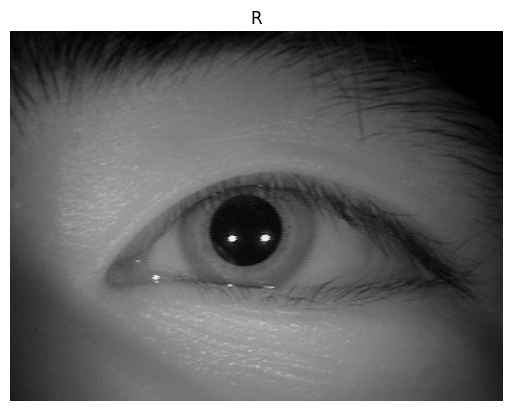

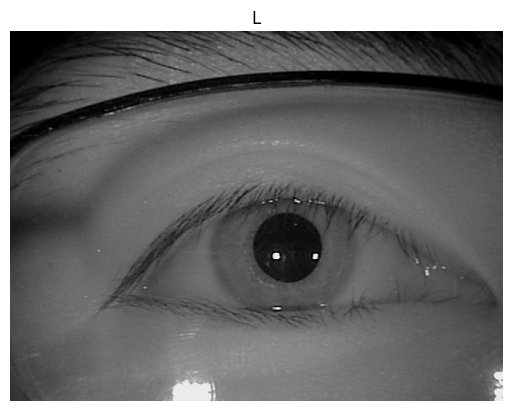

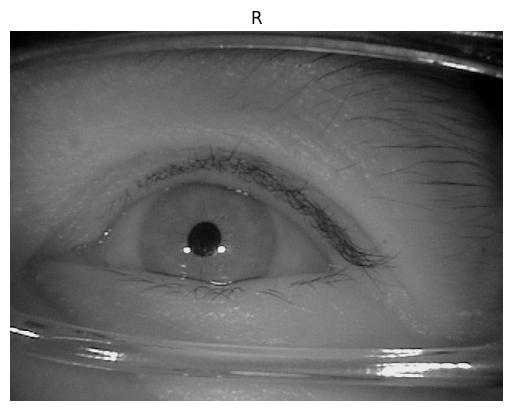

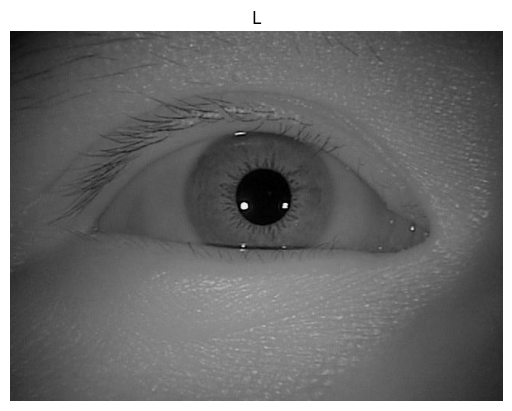

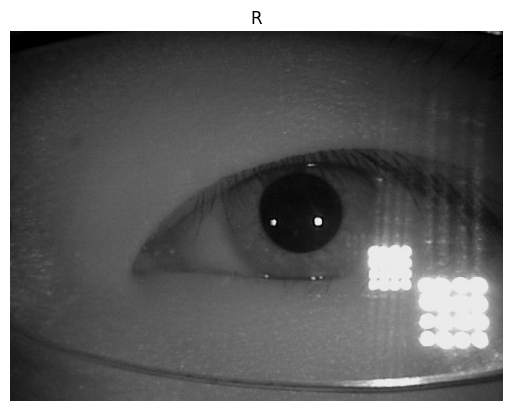

In [ ]:
# Display n random sample images
def display_sample_images_simple(image_paths, n_samples=5):
    samples = np.random.choice(image_paths, min(n_samples, len(image_paths)), replace=False)

    for img_path in samples:
        img = cv2.imread(str(img_path))
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img_rgb)
            plt.title(f'{img_path.parent.name}')
            plt.axis('off')
            plt.show()

# Use it
if len(all_imgs) > 0:
    display_sample_images_simple(all_imgs, n_samples=5)

Total images: 20000
Total subjects: 2
Average images per subject: 10000.00
Min images per subject: 10000
Max images per subject: 10000


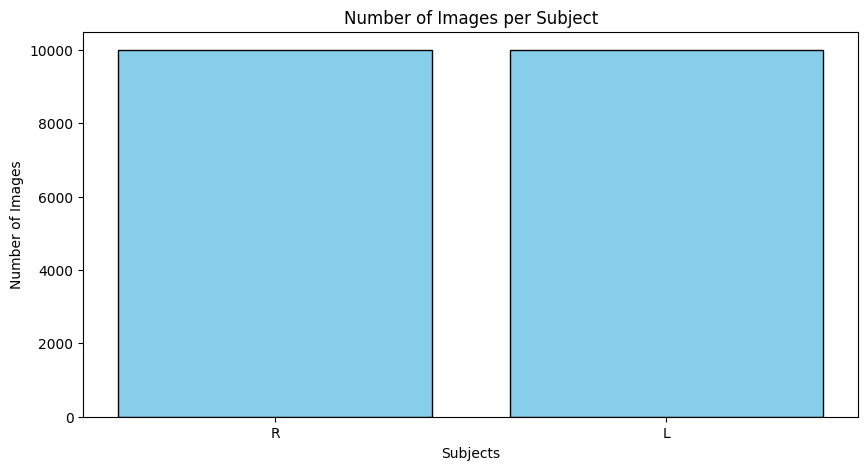

In [ ]:
# Analyze dataset statistics
def analyse_data(image_paths):
    subjects = {}

    for img_path in image_paths:
        subject_id = img_path.parent.name
        subjects.setdefault(subject_id, []).append(img_path)

    total_images = len(image_paths)
    total_subjects = len(subjects)
    images_per_subject = [len(imgs) for imgs in subjects.values()]

    print(f"Total images: {total_images}")
    print(f"Total subjects: {total_subjects}")
    print(f"Average images per subject: {total_images / total_subjects:.2f}")
    print(f"Min images per subject: {min(images_per_subject)}")
    print(f"Max images per subject: {max(images_per_subject)}")

    # Bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(subjects.keys(), images_per_subject, color='skyblue', edgecolor='black')
    plt.xlabel('Subjects')
    plt.ylabel('Number of Images')
    plt.title("Number of Images per Subject")
    plt.show()

    return subjects

subject_dict = analyse_data(all_imgs)


#EYE DETECTION, IRIS DETECTION & SEGMENTATION

# STEP 1: EYE DETECTION

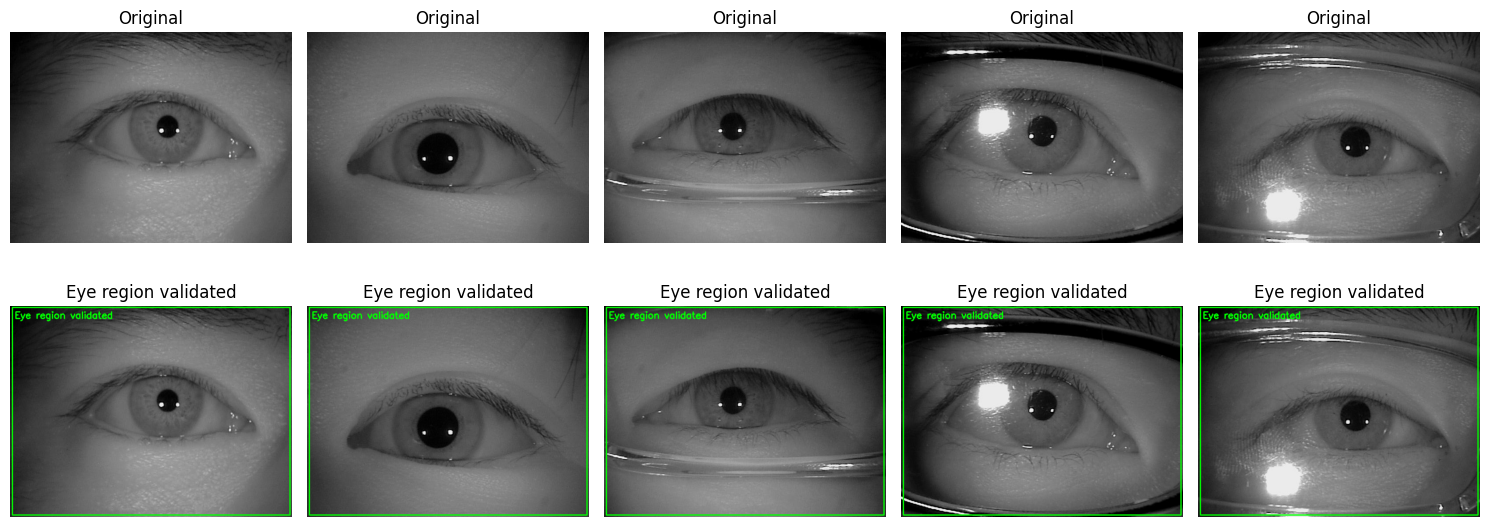

In [ ]:
class EyeDetection:
    def __init__(self):
        pass

    def detect_eye_region(self, image):
        """
        For iris datasets CASIA, images are already cropped to eye region
        So we just validate and return the image
        """
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        h, w = gray.shape
        if h < 50 or w < 50:
            return None, 'image too small'

        return gray, 'Eye region validated'

    def visualize_eye_detection(self, image, eye_region):
        """Visualize eye detection result"""
        if eye_region is None:
            return image

        vis_image = image.copy()
        if len(vis_image.shape) == 2:
            vis_image = cv2.cvtColor(vis_image, cv2.COLOR_GRAY2BGR)

        h, w = vis_image.shape[:2]

        # Draw green border (eye already cropped)
        cv2.rectangle(vis_image, (5, 5), (w - 5, h - 5), (0, 255, 0), 2)
        cv2.putText(
            vis_image, 'Eye region validated', (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2
        )

        return vis_image
eye_detector = EyeDetection()

# Pick 5 images to visualize
sample_imgs = np.random.choice(all_imgs, min(5, len(all_imgs)), replace=False)

fig, axes = plt.subplots(2, len(sample_imgs), figsize=(15, 6))

# Counter for visualization
vis_idx = 0

# Loop through all images
for img_path in sample_imgs:
    img = cv2.imread(str(img_path))
    if img is None:
        continue

    # Detect eye region
    eye_region, status = eye_detector.detect_eye_region(img)

    # Only visualize if this image is in sample_imgs
    if img_path in sample_imgs:
        vis_img = eye_detector.visualize_eye_detection(img, eye_region)

        # Original image
        axes[0, vis_idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0, vis_idx].set_title("Original")
        axes[0, vis_idx].axis("off")

        # Eye validated image
        axes[1, vis_idx].imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        axes[1, vis_idx].set_title(status)
        axes[1, vis_idx].axis("off")

        vis_idx += 1

plt.tight_layout()
plt.show()


# STAGE 2: IRIS DETECTION

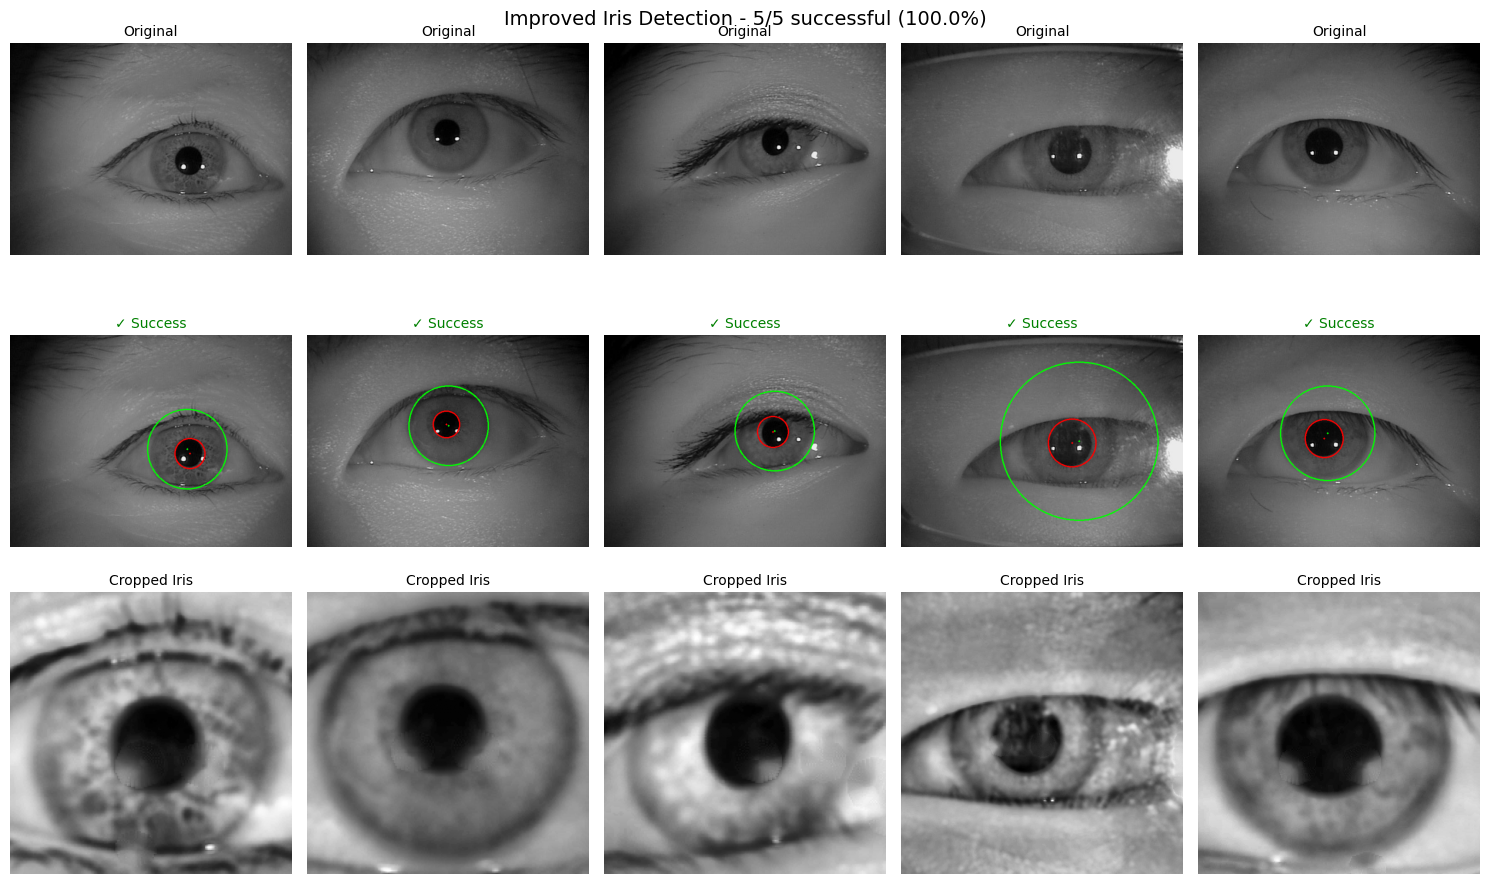


DETECTION SUMMARY
Successful: 5/5 (100.0%)


In [ ]:
class IrisDetection:
    def __init__(self, pupil_range=(15, 80), iris_range=(90, 180), pad_ratio=0.1):
        """
        Enhanced iris detection with improved boundary detection

        Args:
            pupil_range: (min_radius, max_radius) for pupil detection
            iris_range: (min_radius, max_radius) for iris detection
            pad_ratio: padding ratio for cropping
        """
        self.pupil_range = pupil_range
        self.iris_range = iris_range
        self.pad_ratio = pad_ratio

    def preprocess_for_detection(self, eye_image):
        """Enhanced preprocessing with better reflection removal"""
        gray = cv2.cvtColor(eye_image, cv2.COLOR_BGR2GRAY) if len(eye_image.shape) == 3 else eye_image

        # Bilateral filter preserves edges while smoothing
        blurred = cv2.bilateralFilter(gray, 9, 75, 75)

        # Aggressive reflection removal
        reflection_mask = cv2.inRange(blurred, 180, 255)  # Lower threshold
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
        reflection_mask = cv2.dilate(reflection_mask, kernel, iterations=3)

        # Inpaint reflections
        cleaned = cv2.inpaint(blurred, reflection_mask, 9, cv2.INPAINT_TELEA)

        # Enhance contrast
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(cleaned)

        # Normalize
        normalized = cv2.normalize(enhanced, None, 0, 255, cv2.NORM_MINMAX)

        return normalized, cleaned

    def detect_pupil(self, gray, blurred):
        """Robust pupil detection with intensity validation"""
        h, w = gray.shape
        center_x, center_y = w // 2, h // 2

        # Multiple attempts with different parameters
        param_sets = [
            {'param1': 50, 'param2': 30, 'dp': 1},
            {'param1': 40, 'param2': 35, 'dp': 1},
            {'param1': 60, 'param2': 25, 'dp': 1.2},
            {'param1': 45, 'param2': 28, 'dp': 1},
        ]

        all_circles = []

        for params in param_sets:
            circles = cv2.HoughCircles(
                blurred,
                cv2.HOUGH_GRADIENT,
                dp=params['dp'],
                minDist=40,
                param1=params['param1'],
                param2=params['param2'],
                minRadius=self.pupil_range[0],
                maxRadius=self.pupil_range[1]
            )

            if circles is not None:
                all_circles.extend(circles[0])

        if not all_circles:
            return None

        # Score each candidate
        best_circle = None
        best_score = float('inf')

        for circle in all_circles:
            cx, cy, cr = int(circle[0]), int(circle[1]), int(circle[2])

            # Boundary check
            if cx < cr or cy < cr or cx >= w - cr or cy >= h - cr:
                continue

            # Distance from center
            dist_center = np.sqrt((cx - center_x)**2 + (cy - center_y)**2)

            # Check intensity (pupil should be very dark)
            mask = np.zeros(gray.shape, dtype=np.uint8)
            cv2.circle(mask, (cx, cy), cr, 255, -1)
            avg_intensity = cv2.mean(gray, mask=mask)[0]

            # Check edge strength at boundary (strong edge = good pupil boundary)
            edge_mask = np.zeros(gray.shape, dtype=np.uint8)
            cv2.circle(edge_mask, (cx, cy), cr, 255, 2)
            edges = cv2.Canny(gray, 30, 100)
            edge_strength = cv2.mean(edges, mask=edge_mask)[0]

            # Composite score: prefer dark, centered circles with strong edges
            score = (dist_center * 0.5) + (avg_intensity * 2) - (edge_strength * 10)

            if score < best_score and avg_intensity < 80:  # Must be dark
                best_score = score
                best_circle = circle

        if best_circle is not None:
            return np.uint16(np.around(best_circle))

        return None

    def detect_iris_integrodifferential(self, gray, pupil_circle):
        """
        Integro-differential operator approach for iris detection
        Searches for maximum change in intensity along circular paths
        """
        if pupil_circle is None:
            return None

        px, py, pr = int(pupil_circle[0]), int(pupil_circle[1]), int(pupil_circle[2])
        h, w = gray.shape

        # Apply Gaussian blur for smoother gradients
        blurred = cv2.GaussianBlur(gray, (5, 5), 1)

        # Search range for iris radius (should be larger than pupil)
        min_r = max(self.iris_range[0], int(pr * 2.5))
        max_r = min(self.iris_range[1], min(px, py, w-px, h-py) - 5)

        # Search grid around pupil center (allow slight offset)
        search_offset = int(pr * 0.3)
        cx_range = range(max(px - search_offset, 0), min(px + search_offset + 1, w))
        cy_range = range(max(py - search_offset, 0), min(py + search_offset + 1, h))

        best_response = -float('inf')
        best_circle = None

        # Test different centers and radii
        for cx in cx_range[::2]:  # Step by 2 for speed
            for cy in cy_range[::2]:
                for r in range(min_r, max_r, 2):
                    # Sample points on circle
                    response = self.compute_circular_gradient(blurred, cx, cy, r)

                    if response > best_response:
                        best_response = response
                        best_circle = np.array([cx, cy, r], dtype=np.uint16)

        return best_circle

    def compute_circular_gradient(self, image, cx, cy, r, n_points=36):
        """
        Compute gradient strength along a circle
        High gradient = strong boundary
        """
        h, w = image.shape

        # Generate points on circle
        angles = np.linspace(0, 2*np.pi, n_points, endpoint=False)
        points_x = (cx + r * np.cos(angles)).astype(int)
        points_y = (cy + r * np.sin(angles)).astype(int)

        # Keep points within bounds
        valid = (points_x >= 1) & (points_x < w-1) & (points_y >= 1) & (points_y < h-1)
        points_x = points_x[valid]
        points_y = points_y[valid]

        if len(points_x) < n_points // 2:
            return -float('inf')

        # Compute radial gradient (intensity change from inside to outside)
        inner_r = max(1, r - 3)
        outer_r = min(max(h, w), r + 3)

        inner_x = (cx + inner_r * np.cos(angles)).astype(int)
        inner_y = (cy + inner_r * np.sin(angles)).astype(int)
        outer_x = (cx + outer_r * np.cos(angles)).astype(int)
        outer_y = (cy + outer_r * np.sin(angles)).astype(int)

        # Keep within bounds
        valid = ((inner_x >= 0) & (inner_x < w) & (inner_y >= 0) & (inner_y < h) &
                 (outer_x >= 0) & (outer_x < w) & (outer_y >= 0) & (outer_y < h))

        if valid.sum() < n_points // 2:
            return -float('inf')

        inner_x = inner_x[valid]
        inner_y = inner_y[valid]
        outer_x = outer_x[valid]
        outer_y = outer_y[valid]

        # Get intensities
        inner_intensity = image[inner_y, inner_x].astype(float)
        outer_intensity = image[outer_y, outer_x].astype(float)

        # Gradient = outer - inner (iris is darker than sclera)
        gradient = outer_intensity - inner_intensity

        # Return sum of gradients (stronger boundary = higher value)
        return np.sum(gradient)

    def detect_iris_hybrid(self, gray, blurred, pupil_circle):
        """
        Hybrid approach: try both Hough and integro-differential
        """
        if pupil_circle is None:
            return None

        px, py, pr = int(pupil_circle[0]), int(pupil_circle[1]), int(pupil_circle[2])

        # Method 1: Integro-differential (more accurate)
        iris_integ = self.detect_iris_integrodifferential(gray, pupil_circle)

        # Method 2: Enhanced edge-based Hough
        # Create edge map emphasizing iris boundary
        edges = cv2.Canny(blurred, 15, 60)

        # Remove edges near pupil
        mask = np.ones(edges.shape, dtype=np.uint8) * 255
        cv2.circle(mask, (px, py), int(pr * 1.5), 0, -1)
        edges = cv2.bitwise_and(edges, edges, mask=mask)

        # Morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

        circles = cv2.HoughCircles(
            edges,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=100,
            param1=40,
            param2=12,
            minRadius=self.iris_range[0],
            maxRadius=self.iris_range[1]
        )

        iris_hough = None
        if circles is not None:
            circles = np.uint16(np.around(circles))

            # Find best match
            best_score = float('inf')
            for circle in circles[0]:
                ix, iy, ir = int(circle[0]), int(circle[1]), int(circle[2])

                # Must contain pupil
                center_dist = np.sqrt((px - ix)**2 + (py - iy)**2)
                if ir <= pr * 1.5 or ir > pr * 5:
                    continue
                if center_dist > pr * 0.5:
                    continue

                score = center_dist
                if score < best_score:
                    best_score = score
                    iris_hough = circle

        # Choose best result
        if iris_integ is not None and iris_hough is not None:
            # Compare both and choose better one
            ix_integ, iy_integ, ir_integ = iris_integ
            ix_hough, iy_hough, ir_hough = iris_hough

            # Prefer integro-differential if close
            dist_diff = abs(ir_integ - ir_hough)
            if dist_diff < 20:
                return iris_integ
            else:
                return iris_hough if ir_hough > ir_integ else iris_integ

        return iris_integ if iris_integ is not None else iris_hough

    def validate_detection(self, pupil, iris, image_shape):
        """Strict validation"""
        if pupil is None or iris is None:
            return False

        h, w = image_shape
        px, py, pr = int(pupil[0]), int(pupil[1]), int(pupil[2])
        ix, iy, ir = int(iris[0]), int(iris[1]), int(iris[2])

        # Boundary checks
        if not (pr < px < w - pr and pr < py < h - pr):
            return False
        if not (ir < ix < w - ir and ir < iy < h - ir):
            return False

        # Size relationship: iris should be 2-4x larger than pupil
        size_ratio = ir / pr
        if size_ratio < 2.0 or size_ratio > 5.0:
            return False

        # Concentricity: centers should be very close
        center_dist = np.sqrt((px - ix)**2 + (py - iy)**2)
        if center_dist > pr * 0.6:
            return False

        return True

    def crop_iris(self, image, circle):
        """Crop iris region with padding"""
        if circle is None:
            return None

        x, y, r = int(circle[0]), int(circle[1]), int(circle[2])
        h, w = image.shape[:2]

        pad = int(r * self.pad_ratio)
        x1 = max(0, x - r - pad)
        x2 = min(w, x + r + pad)
        y1 = max(0, y - r - pad)
        y2 = min(h, y + r + pad)

        return image[y1:y2, x1:x2]

    def detect(self, eye_image):
        """Main detection pipeline"""
        gray, blurred = self.preprocess_for_detection(eye_image)

        # Detect pupil
        pupil = self.detect_pupil(gray, blurred)

        # Detect iris using hybrid method
        iris = self.detect_iris_hybrid(gray, blurred, pupil)

        # Validate
        success = self.validate_detection(pupil, iris, gray.shape)

        # Crop
        cropped_iris = self.crop_iris(gray, iris) if success else None

        return {
            'gray': gray,
            'pupil': pupil,
            'iris': iris,
            'cropped_iris': cropped_iris,
            'success': success
        }

    def visualize_iris_detection(self, image, result):
        """Visualize detection with circles"""
        if len(image.shape) == 2:
            vis_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        else:
            vis_image = image.copy()

        # Draw pupil (red)
        if result['pupil'] is not None:
            px, py, pr = result['pupil']
            cv2.circle(vis_image, (int(px), int(py)), int(pr), (0, 0, 255), 2)
            cv2.circle(vis_image, (int(px), int(py)), 2, (0, 0, 255), -1)

        # Draw iris (green)
        if result['iris'] is not None:
            ix, iy, ir = result['iris']
            cv2.circle(vis_image, (int(ix), int(iy)), int(ir), (0, 255, 0), 2)
            cv2.circle(vis_image, (int(ix), int(iy)), 2, (0, 255, 0), -1)

        return vis_image


# ============================================================================
# EXECUTE DETECTION
# ============================================================================

# Initialize with adjusted parameters
iris_detector = IrisDetection(
    pupil_range=(15, 80),      # Slightly larger minimum
    iris_range=(90, 180),      # Wider range for iris
    pad_ratio=0.1
)

# Run detection
try:
    sample_imgs = np.random.choice(all_imgs, min(5, len(all_imgs)), replace=False)

    fig, axes = plt.subplots(3, len(sample_imgs), figsize=(15, 9))

    if len(sample_imgs) == 1:
        axes = axes.reshape(-1, 1)

    success_count = 0

    for idx, img_path in enumerate(sample_imgs):
        img = cv2.imread(str(img_path))

        if img is None:
            print(f"Failed to load: {img_path}")
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img

        # Detect
        result = iris_detector.detect(gray)
        vis_img = iris_detector.visualize_iris_detection(gray, result)

        if result['success']:
            success_count += 1

        # Plot
        axes[0, idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if len(img.shape) == 3 else img, cmap='gray')
        axes[0, idx].set_title("Original", fontsize=10)
        axes[0, idx].axis("off")

        axes[1, idx].imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        status = "✓ Success" if result['success'] else "✗ Failed"
        axes[1, idx].set_title(status, fontsize=10, color='green' if result['success'] else 'red')
        axes[1, idx].axis("off")

        if result['cropped_iris'] is not None:
            axes[2, idx].imshow(result['cropped_iris'], cmap='gray')
            axes[2, idx].set_title("Cropped Iris", fontsize=10)
        else:
            axes[2, idx].text(0.5, 0.5, "Failed", ha='center', va='center', fontsize=12)
            axes[2, idx].set_title("Cropped Iris", fontsize=10)
        axes[2, idx].axis("off")

    plt.tight_layout()
    plt.suptitle(f"Improved Iris Detection - {success_count}/{len(sample_imgs)} successful ({100*success_count/len(sample_imgs):.1f}%)",
                 fontsize=14, y=0.98)
    plt.show()

    print(f"\n{'='*60}")
    print(f"DETECTION SUMMARY")
    print(f"{'='*60}")
    print(f"Successful: {success_count}/{len(sample_imgs)} ({100*success_count/len(sample_imgs):.1f}%)")
    print(f"{'='*60}")

except NameError:
    print("ERROR: 'all_imgs' not found!")
    print("Load images first:")
    print("  all_imgs = glob.glob('path/**/*.jpg', recursive=True)")
except Exception as e:
    print(f"ERROR: {e}")

Segmenting Iris Images:   1%|          | 121/20000 [01:32<4:37:06,  1.20it/s]/tmp/ipython-input-1400148510.py:130: RuntimeWarning: overflow encountered in scalar subtract
  dist_diff = abs(iris_integ[2]-iris_hough[2])
Segmenting Iris Images: 100%|██████████| 20000/20000 [4:51:09<00:00,  1.14it/s]


Saved 19669/20000 cropped iris images.


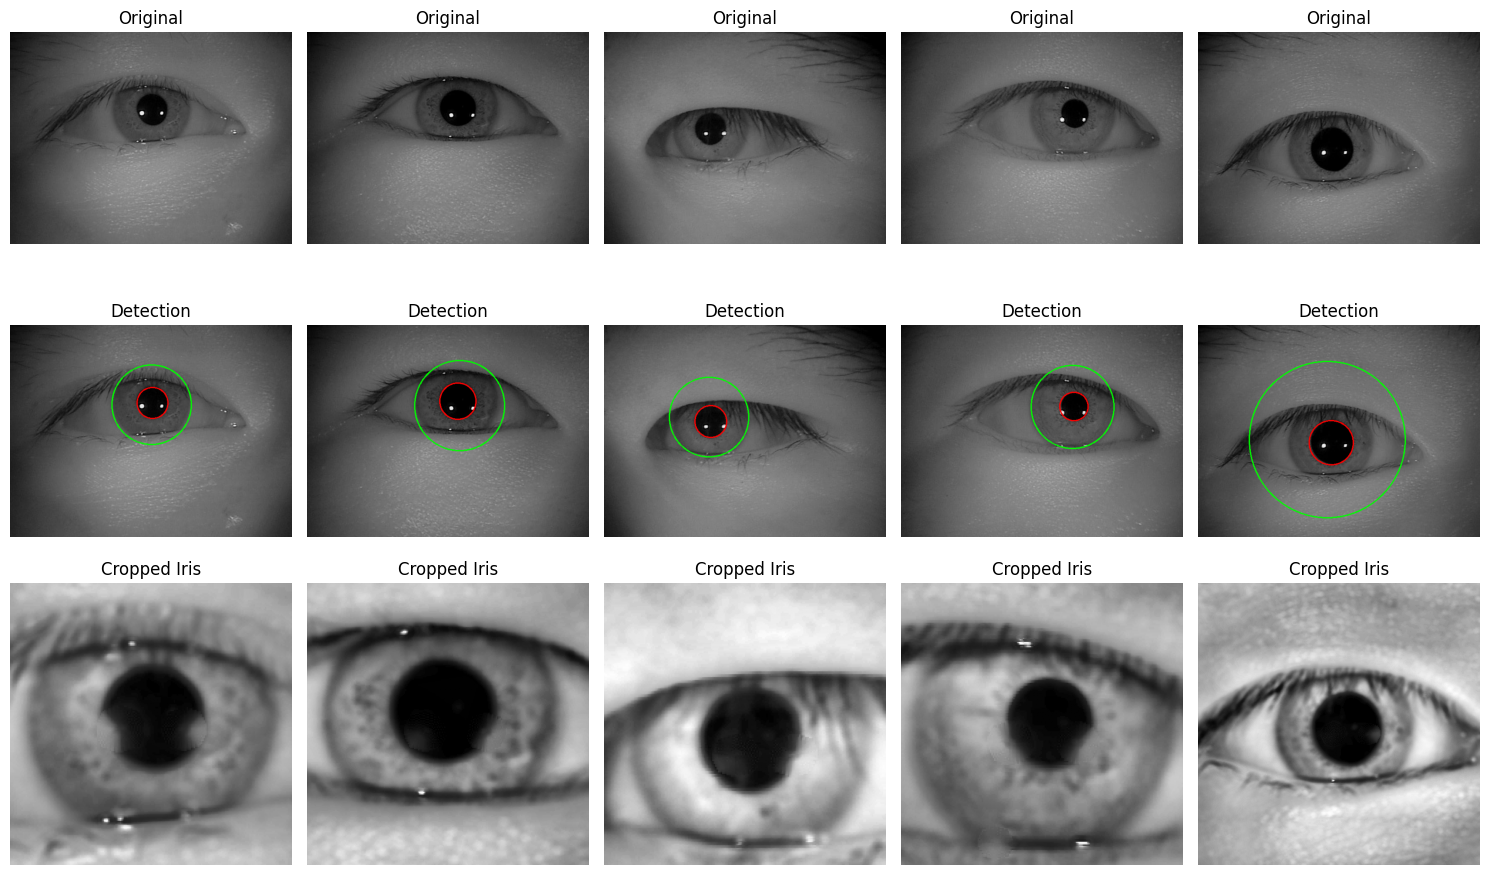

In [ ]:
from pathlib import Path
import random
import glob
from tqdm import tqdm  # For progress bar
import cv2
import numpy as np
import matplotlib.pyplot as plt

class IrisDetection:
    def __init__(self, pupil_range=(15, 80), iris_range=(90, 180), pad_ratio=0.1):
        self.pupil_range = pupil_range
        self.iris_range = iris_range
        self.pad_ratio = pad_ratio

    def preprocess_for_detection(self, eye_image):
        gray = cv2.cvtColor(eye_image, cv2.COLOR_BGR2GRAY) if len(eye_image.shape) == 3 else eye_image
        blurred = cv2.bilateralFilter(gray, 9, 75, 75)
        reflection_mask = cv2.inRange(blurred, 180, 255)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
        reflection_mask = cv2.dilate(reflection_mask, kernel, iterations=3)
        cleaned = cv2.inpaint(blurred, reflection_mask, 9, cv2.INPAINT_TELEA)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(cleaned)
        normalized = cv2.normalize(enhanced, None, 0, 255, cv2.NORM_MINMAX)
        return normalized, cleaned

    def detect_pupil(self, gray, blurred):
        h, w = gray.shape
        center_x, center_y = w // 2, h // 2
        param_sets = [{'param1': 50, 'param2': 30, 'dp': 1},
                      {'param1': 40, 'param2': 35, 'dp': 1},
                      {'param1': 60, 'param2': 25, 'dp': 1.2},
                      {'param1': 45, 'param2': 28, 'dp': 1}]
        all_circles = []
        for params in param_sets:
            circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=params['dp'],
                                       minDist=40, param1=params['param1'], param2=params['param2'],
                                       minRadius=self.pupil_range[0], maxRadius=self.pupil_range[1])
            if circles is not None:
                all_circles.extend(circles[0])
        if not all_circles:
            return None
        best_circle = None
        best_score = float('inf')
        for circle in all_circles:
            cx, cy, cr = int(circle[0]), int(circle[1]), int(circle[2])
            if cx < cr or cy < cr or cx >= w - cr or cy >= h - cr:
                continue
            dist_center = np.sqrt((cx - center_x)**2 + (cy - center_y)**2)
            mask = np.zeros(gray.shape, dtype=np.uint8)
            cv2.circle(mask, (cx, cy), cr, 255, -1)
            avg_intensity = cv2.mean(gray, mask=mask)[0]
            edge_mask = np.zeros(gray.shape, dtype=np.uint8)
            cv2.circle(edge_mask, (cx, cy), cr, 255, 2)
            edges = cv2.Canny(gray, 30, 100)
            edge_strength = cv2.mean(edges, mask=edge_mask)[0]
            score = (dist_center * 0.5) + (avg_intensity * 2) - (edge_strength * 10)
            if score < best_score and avg_intensity < 80:
                best_score = score
                best_circle = circle
        return np.uint16(np.around(best_circle)) if best_circle is not None else None

    def compute_circular_gradient(self, image, cx, cy, r, n_points=36):
        h, w = image.shape
        angles = np.linspace(0, 2*np.pi, n_points, endpoint=False)
        points_x = (cx + r * np.cos(angles)).astype(int)
        points_y = (cy + r * np.sin(angles)).astype(int)
        valid = (points_x >= 1) & (points_x < w-1) & (points_y >= 1) & (points_y < h-1)
        points_x, points_y = points_x[valid], points_y[valid]
        if len(points_x) < n_points // 2:
            return -float('inf')
        inner_r, outer_r = max(1, r-3), min(max(h,w), r+3)
        inner_x = (cx + inner_r * np.cos(angles)).astype(int)
        inner_y = (cy + inner_r * np.sin(angles)).astype(int)
        outer_x = (cx + outer_r * np.cos(angles)).astype(int)
        outer_y = (cy + outer_r * np.sin(angles)).astype(int)
        valid = ((inner_x >=0)&(inner_x<w)&(inner_y>=0)&(inner_y<h)&
                 (outer_x>=0)&(outer_x<w)&(outer_y>=0)&(outer_y<h))
        inner_x, inner_y, outer_x, outer_y = inner_x[valid], inner_y[valid], outer_x[valid], outer_y[valid]
        if valid.sum() < n_points // 2:
            return -float('inf')
        gradient = image[outer_y, outer_x].astype(float) - image[inner_y, inner_x].astype(float)
        return np.sum(gradient)

    def detect_iris_integrodifferential(self, gray, pupil_circle):
        if pupil_circle is None:
            return None
        px, py, pr = map(int, pupil_circle[:3])
        h, w = gray.shape
        blurred = cv2.GaussianBlur(gray, (5,5), 1)
        min_r = max(self.iris_range[0], int(pr*2.5))
        max_r = min(self.iris_range[1], min(px, py, w-px, h-py)-5)
        search_offset = int(pr*0.3)
        best_response, best_circle = -float('inf'), None
        for cx in range(max(px-search_offset,0), min(px+search_offset+1,w), 2):
            for cy in range(max(py-search_offset,0), min(py+search_offset+1,h), 2):
                for r in range(min_r, max_r, 2):
                    response = self.compute_circular_gradient(blurred, cx, cy, r)
                    if response > best_response:
                        best_response = response
                        best_circle = np.array([cx, cy, r], dtype=np.uint16)
        return best_circle

    def detect_iris_hybrid(self, gray, blurred, pupil_circle):
        if pupil_circle is None:
            return None
        px, py, pr = map(int, pupil_circle[:3])
        iris_integ = self.detect_iris_integrodifferential(gray, pupil_circle)
        edges = cv2.Canny(blurred, 15, 60)
        mask = np.ones(edges.shape, dtype=np.uint8)*255
        cv2.circle(mask, (px, py), int(pr*1.5), 0, -1)
        edges = cv2.bitwise_and(edges, edges, mask=mask)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
        circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=100, param1=40,
                                   param2=12, minRadius=self.iris_range[0], maxRadius=self.iris_range[1])
        iris_hough = None
        if circles is not None:
            circles = np.uint16(np.around(circles))
            best_score = float('inf')
            for circle in circles[0]:
                ix, iy, ir = map(int, circle)
                center_dist = np.sqrt((px-ix)**2 + (py-iy)**2)
                if ir <= pr*1.5 or ir > pr*5 or center_dist > pr*0.5:
                    continue
                if center_dist < best_score:
                    best_score = center_dist
                    iris_hough = circle
        if iris_integ is not None and iris_hough is not None:
            dist_diff = abs(iris_integ[2]-iris_hough[2])
            return iris_integ if dist_diff<20 or iris_integ[2]>=iris_hough[2] else iris_hough
        return iris_integ if iris_integ is not None else iris_hough

    def validate_detection(self, pupil, iris, image_shape):
        if pupil is None or iris is None:
            return False
        h, w = image_shape
        px, py, pr = map(int, pupil[:3])
        ix, iy, ir = map(int, iris[:3])
        if not (pr < px < w-pr and pr < py < h-pr): return False
        if not (ir < ix < w-ir and ir < iy < h-ir): return False
        size_ratio = ir/pr
        if size_ratio<2.0 or size_ratio>5.0: return False
        if np.sqrt((px-ix)**2 + (py-iy)**2) > pr*0.6: return False
        return True

    def crop_iris(self, image, circle):
        if circle is None:
            return None
        x, y, r = map(int, circle[:3])
        h, w = image.shape[:2]
        pad = int(r*self.pad_ratio)
        x1, x2 = max(0, x-r-pad), min(w, x+r+pad)
        y1, y2 = max(0, y-r-pad), min(h, y+r+pad)
        return image[y1:y2, x1:x2]

    def detect(self, eye_image):
        gray, blurred = self.preprocess_for_detection(eye_image)
        pupil = self.detect_pupil(gray, blurred)
        iris = self.detect_iris_hybrid(gray, blurred, pupil)
        success = self.validate_detection(pupil, iris, gray.shape)
        cropped_iris = self.crop_iris(gray, iris) if success else None
        return {'gray': gray, 'pupil': pupil, 'iris': iris, 'cropped_iris': cropped_iris, 'success': success}

    def visualize_iris_detection(self, image, result):
        vis_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) if len(image.shape)==2 else image.copy()
        if result['pupil'] is not None:
            px, py, pr = map(int, result['pupil'][:3])
            cv2.circle(vis_image, (px, py), pr, (0,0,255), 2)
        if result['iris'] is not None:
            ix, iy, ir = map(int, result['iris'][:3])
            cv2.circle(vis_image, (ix, iy), ir, (0,255,0), 2)
        return vis_image

# ==============================
# EXECUTION
# ==============================

# Set output path to Google Drive
output_dir = Path("/content/drive/MyDrive/IRIS_RECOGNITION_PROJECT/IRIS_CROPPED_OUTPUT")
output_dir.mkdir(parents=True, exist_ok=True)

iris_detector = IrisDetection()
success_count = 0

# Wrap the loop with tqdm for progress display
for img_path in tqdm(all_imgs, desc="Segmenting Iris Images"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Failed to load: {img_path}")
        continue
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape)==3 else img
    result = iris_detector.detect(gray)
    if result['cropped_iris'] is not None:
        stem = Path(img_path).stem
        cv2.imwrite(str(output_dir/f"{stem}_iris.png"), result['cropped_iris'])
        success_count += 1

print(f"Saved {success_count}/{len(all_imgs)} cropped iris images.")

# Visualize 5 random samples
sample_imgs = random.sample(all_imgs, min(5, len(all_imgs)))
fig, axes = plt.subplots(3, len(sample_imgs), figsize=(15,9))
if len(sample_imgs)==1: axes = axes.reshape(-1,1)
for idx, img_path in enumerate(sample_imgs):
    img = cv2.imread(str(img_path))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape)==3 else img
    result = iris_detector.detect(gray)
    vis_img = iris_detector.visualize_iris_detection(gray, result)
    axes[0, idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if len(img.shape)==3 else img, cmap='gray')
    axes[0, idx].set_title("Original"); axes[0, idx].axis("off")
    axes[1, idx].imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    axes[1, idx].set_title("Detection"); axes[1, idx].axis("off")
    if result['cropped_iris'] is not None:
        axes[2, idx].imshow(result['cropped_iris'], cmap='gray')
        axes[2, idx].set_title("Cropped Iris")
    else:
        axes[2, idx].text(0.5,0.5,"Failed",ha='center',va='center',fontsize=12)
        axes[2, idx].set_title("Cropped Iris")
    axes[2, idx].axis("off")
plt.tight_layout(); plt.show()

#Normalization

Iris normalization is applied to transform the segmented circular iris into a fixed-size rectangular representation, making the iris texture invariant to pupil dilation and illumination changes.

This class takes the iris segmented (circle inside a circle) and:

➡️ unwraps it into a rectangle
➡️ so that pupil dilation does not change the iris pattern position

This is called iris normalization or rubber sheet model.

In [ ]:
from pathlib import Path
import cv2
import numpy as np

# 1. Recréer le dossier complètement
output_norm_dir = Path("/content/drive/MyDrive/IRIS_RECOGNITION_PROJECT/IRIS_NORMALIZED_OUTPUT")

# Supprimer s'il existe (peut-être corrompu)
import shutil
if output_norm_dir.exists():
    shutil.rmtree(output_norm_dir)

# Recréer proprement
output_norm_dir.mkdir(parents=True, exist_ok=True)

print(f"✅ Dossier créé: {output_norm_dir}")
print(f"📁 Existe: {output_norm_dir.exists()}")

# 2. Test de sauvegarde
test_img = np.random.randint(0, 255, (64, 512), dtype=np.uint8)
test_path = output_norm_dir / "test_write.png"

success = cv2.imwrite(str(test_path), test_img)
print(f"\n💾 Test sauvegarde: {success}")
print(f"📄 Fichier créé: {test_path.exists()}")

if test_path.exists():
    print(f"✅ SUCCÈS! Le dossier fonctionne maintenant")
    # Nettoyer le test
    test_path.unlink()
else:
    print(f"❌ ÉCHEC! Essayons un autre emplacement...")

    # Plan B: Utiliser /content/ (local) puis copier
    local_dir = Path("/content/IRIS_NORMALIZED_OUTPUT")
    local_dir.mkdir(exist_ok=True)

    test_local = local_dir / "test.png"
    success2 = cv2.imwrite(str(test_local), test_img)

    if success2:
        print(f"✅ Sauvegarde locale fonctionne!")
        print(f"💡 Utilisez: {local_dir}")
        print(f"   Puis copiez vers Drive après")

✅ Dossier créé: /content/drive/MyDrive/IRIS_RECOGNITION_PROJECT/IRIS_NORMALIZED_OUTPUT
📁 Existe: True

💾 Test sauvegarde: True
📄 Fichier créé: True
✅ SUCCÈS! Le dossier fonctionne maintenant


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class IrisNormalizationGPU:
    def __init__(self, radial_res=64, angular_res=512, device='cuda'):
        self.radial_res = radial_res
        self.angular_res = angular_res
        self.device = device if torch.cuda.is_available() else 'cpu'

        if self.device == 'cpu':
            print("⚠️ CUDA not available, using CPU")
        else:
            print(f"✅ Using GPU: {torch.cuda.get_device_name(0)}")

    def enhanced_normalized_iris(self, normalized):
        """Enhance contrast using CLAHE"""
        if normalized is None:
            return None

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(normalized)
        enhanced = cv2.normalize(enhanced, None, 0, 255, cv2.NORM_MINMAX)
        return enhanced


class AdaptiveIrisDetection:
    """Hybrid detection: try advanced methods first, fallback to fixed normalization"""

    def detect_with_fallback(self, img):
        """Try multiple detection strategies"""

        # Strategy 1: Try Hough Circles
        result = self._hough_detection(img)
        if result['success']:
            result['method'] = 'hough'
            return result

        # Strategy 2: Try edge-based detection
        result = self._edge_based_detection(img)
        if result['success']:
            result['method'] = 'edge'
            return result

        # Strategy 3: Fallback to centered estimation
        result = self._centered_estimation(img)
        result['method'] = 'centered'
        return result

    def _hough_detection(self, img):
        """Original Hough circle detection"""
        try:
            gray = cv2.GaussianBlur(img, (5, 5), 0)

            pupil_circles = cv2.HoughCircles(
                gray, cv2.HOUGH_GRADIENT, dp=1, minDist=50,
                param1=50, param2=30, minRadius=10, maxRadius=80
            )

            iris_circles = cv2.HoughCircles(
                gray, cv2.HOUGH_GRADIENT, dp=1, minDist=100,
                param1=50, param2=30, minRadius=80, maxRadius=150
            )

            if pupil_circles is not None and iris_circles is not None:
                pupil = pupil_circles[0][0]
                iris = iris_circles[0][0]

                if iris[2] > pupil[2]:
                    return {'success': True, 'pupil': pupil, 'iris': iris, 'gray': img}

            return {'success': False}
        except:
            return {'success': False}

    def _edge_based_detection(self, img):
        """Edge-based circle detection"""
        try:
            blurred = cv2.GaussianBlur(img, (9, 9), 2)
            _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            thresh = cv2.bitwise_not(thresh)

            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if len(contours) > 0:
                largest = max(contours, key=cv2.contourArea)

                if cv2.contourArea(largest) > 100:
                    (px, py), pr = cv2.minEnclosingCircle(largest)

                    H, W = img.shape
                    cx, cy = W/2, H/2
                    ir = min(W, H) * 0.45

                    return {
                        'success': True,
                        'pupil': [px, py, pr],
                        'iris': [cx, cy, ir],
                        'gray': img
                    }

            return {'success': False}
        except:
            return {'success': False}

    def _centered_estimation(self, img):
        """Assume iris is centered (for pre-cropped images)"""
        H, W = img.shape
        cx, cy = W / 2, H / 2

        iris_radius = min(W, H) * 0.45
        pupil_radius = iris_radius * 0.3

        return {
            'success': True,
            'pupil': [cx, cy, pupil_radius],
            'iris': [cx, cy, iris_radius],
            'gray': img
        }


# =========================
# NORMALISATION PROCESS
# =========================
segmented_dir = Path("/content/drive/MyDrive/IRIS_RECOGNITION_PROJECT/IRIS_CROPPED_OUTPUT")
output_norm_dir = Path("/content/drive/MyDrive/IRIS_RECOGNITION_PROJECT/IRIS_NORMALIZED_OUTPUT")

all_imgs = list(segmented_dir.glob("*_iris.png"))

if len(all_imgs) == 0:
    print(f"❌ No images found in {segmented_dir}")
else:
    # Initialize
    iris_norm = IrisNormalizationGPU(radial_res=64, angular_res=512, device='cuda')
    iris_detector = AdaptiveIrisDetection()

    # Track results
    success_count = 0
    failed_count = 0
    saved_count = 0
    method_counts = {'hough': 0, 'edge': 0, 'centered': 0}

    print(f"Processing {len(all_imgs)} images with GPU acceleration...")
    print(f"Device: {iris_norm.device}")
    print(f"Output directory: {output_norm_dir}\n")

    for img_path in tqdm(all_imgs, desc="Normalizing Iris Images"):
        try:
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

            if img is None:
                failed_count += 1
                continue

            # Detect circles
            result = iris_detector.detect_with_fallback(img)
            method_counts[result['method']] += 1

            pupil_circle = result['pupil']
            iris_circle = result['iris']

            px, py, pr = pupil_circle[:3]
            ix, iy, ir = iris_circle[:3]

            # GPU normalization
            img_tensor = torch.from_numpy(result['gray']).float().to(iris_norm.device)
            img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)

            H, W = result['gray'].shape
            r = torch.linspace(0, 1, iris_norm.radial_res, device=iris_norm.device).view(-1, 1)
            theta = torch.linspace(0, 2*np.pi, iris_norm.angular_res, device=iris_norm.device).view(1, -1)

            x = (1 - r) * (px + pr * torch.cos(theta)) + r * (ix + ir * torch.cos(theta))
            y = (1 - r) * (py + pr * torch.sin(theta)) + r * (iy + ir * torch.sin(theta))

            x_norm = (2 * x / W - 1).unsqueeze(0).unsqueeze(-1)
            y_norm = (2 * y / H - 1).unsqueeze(0).unsqueeze(-1)
            grid = torch.cat((x_norm, y_norm), dim=-1)

            normalized = F.grid_sample(img_tensor, grid, mode='bilinear', align_corners=True, padding_mode='zeros')
            normalized_np = normalized[0, 0].cpu().numpy()
            normalized_np = np.clip(normalized_np, 0, 255).astype(np.uint8)

            # Enhance
            enhanced = iris_norm.enhanced_normalized_iris(normalized_np)

            if enhanced is not None:
                stem = img_path.stem
                output_path = output_norm_dir / f"{stem}_norm.png"

                # Save and verify
                write_success = cv2.imwrite(str(output_path), enhanced)

                if write_success and output_path.exists():
                    saved_count += 1
                    success_count += 1
                else:
                    failed_count += 1
                    logger.warning(f"Failed to save {output_path.name}")
            else:
                failed_count += 1

        except Exception as e:
            failed_count += 1
            logger.error(f"Error processing {img_path.name}: {e}")

    # Summary
    print(f"\n{'='*60}")
    print(f"✅ Successfully normalized: {success_count}/{len(all_imgs)}")
    print(f"💾 Successfully saved to disk: {saved_count}/{len(all_imgs)}")
    print(f"❌ Failed: {failed_count}/{len(all_imgs)}")
    print(f"Success rate: {100*success_count/len(all_imgs):.1f}%")
    print(f"Save rate: {100*saved_count/len(all_imgs):.1f}%")
    print(f"{'='*60}")

    print("\n📊 Detection Methods Used:")
    for method, count in method_counts.items():
        print(f"  • {method}: {count} ({100*count/len(all_imgs):.1f}%)")

    # Verify saved files
    print(f"\n🔍 Verification:")
    actual_saved = len(list(output_norm_dir.glob("*_norm.png")))
    print(f"  Files in output directory: {actual_saved}")
    if actual_saved != saved_count:
        print(f"  ⚠️ Warning: Mismatch between counter ({saved_count}) and actual files ({actual_saved})")
    else:
        print(f"  ✅ All files verified!")

✅ Using GPU: Tesla T4
Processing 19669 images with GPU acceleration...
Device: cuda
Output directory: /content/drive/MyDrive/IRIS_RECOGNITION_PROJECT/IRIS_NORMALIZED_OUTPUT



Normalizing Iris Images: 100%|██████████| 19669/19669 [15:25<00:00, 21.26it/s]



✅ Successfully normalized: 19669/19669
💾 Successfully saved to disk: 19669/19669
❌ Failed: 0/19669
Success rate: 100.0%
Save rate: 100.0%

📊 Detection Methods Used:
  • hough: 11450 (58.2%)
  • edge: 8219 (41.8%)
  • centered: 0 (0.0%)

🔍 Verification:
  Files in output directory: 19669
  ✅ All files verified!


#Classification

In [3]:
import numpy as np
import cv2
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from collections import Counter

In [4]:
#loading Data
data_dir = Path("/content/drive/MyDrive/IRIS_RECOGNITION_PROJECT/IRIS_NORMALIZED_OUTPUT")
all_images = sorted(list(data_dir.glob("*.png")))
print(f"📂 Found {len(all_images)} images")


📂 Found 19669 images


In [5]:
import os
from collections import Counter

def select_top_classes(data_dir, num_classes_target=250, min_images_per_class=10):
    """
    STEP 1: SÉLECTION DES {num_classes_target} CLASSES
    """

    image_paths = []
    labels = []

    # Load all images and extract subject IDs
    for fname in os.listdir(data_dir):
        if fname.lower().endswith((".png", ".jpg", ".jpeg")):
            # Example: S5930_L_01.jpg → S5930
            subject_id = fname.split("_")[0].split("L")[0].split("R")[0]
            image_paths.append(os.path.join(data_dir, fname))
            labels.append(subject_id)

    print(f" Total images trouvées: {len(image_paths)}")
    print(f" Total classes initiales: {len(set(labels))}")

    # Count images per class
    class_counts = Counter(labels)

    # Filter classes with enough images
    filtered_class_counts = Counter({
        c: n for c, n in class_counts.items() if n >= min_images_per_class
    })

    print(f" Après filtrage (<{min_images_per_class} images): {sum(filtered_class_counts.values())} images")
    print(f" Classes restantes: {len(filtered_class_counts)}")

    # Select top N classes
    top_classes = [
        c for c, _ in filtered_class_counts.most_common(num_classes_target)
    ]

    # Keep only selected classes
    final_image_paths = []
    final_labels = []

    for path, label in zip(image_paths, labels):
        if label in top_classes:
            final_image_paths.append(path)
            final_labels.append(label)

    # Display selected class IDs
    print(f"\n IDs des classes sélectionnées (top {num_classes_target}):")
    for i, (class_id, count) in enumerate(
        filtered_class_counts.most_common(num_classes_target), start=1
    ):
        print(f"  {i}. {class_id}: {count} images")

    # Final stats
    print(f"\n {num_classes_target} classes sélectionnées")
    print(f" Total images finales: {len(final_labels)}")
    print(f" Moyenne images/classe: {len(final_labels)/len(set(final_labels)):.1f}")

    return final_image_paths, final_labels

In [6]:


IMG_SIZE = (224, 224)

def create_iris_dataset_from_flat_folder(
    data_dir,
    batch_size=64,
    test_size=0.2,
    augment=True,
    shuffle=True,
    num_classes_target=250
):
    image_paths = []
    labels = []

    # Load paths & labels
    for fname in os.listdir(data_dir):
        if fname.lower().endswith((".png", ".jpg", ".jpeg")):
            subject_id = fname.split("_")[0].split("L")[0]  # Extract ID like S5000
            image_paths.append(os.path.join(data_dir, fname))
            labels.append(subject_id)

    print(f" Found {len(image_paths)} images")

    # Remove classes with <2 samples
    class_counts = Counter(labels)
    valid_classes = {c for c, n in class_counts.items() if n >= 2}
    image_paths = [p for p, l in zip(image_paths, labels) if l in valid_classes]
    labels = [l for l in labels if l in valid_classes]

    print(f" After filtering (<2 removed): {len(image_paths)} images")
    print(f" Classes remaining: {len(set(labels))}")

    # Reduce number of classes
    if len(set(labels)) > num_classes_target:
        print(f" Selecting top {num_classes_target} classes")
        class_counts = Counter(labels)
        top_classes = [c for c, _ in class_counts.most_common(num_classes_target)]
        image_paths = [p for p, l in zip(image_paths, labels) if l in top_classes]
        labels = [l for l in labels if l in top_classes]

    # Encode labels
    unique_labels = sorted(set(labels))
    label_to_id = {lbl: i for i, lbl in enumerate(unique_labels)}
    y = np.array([label_to_id[lbl] for lbl in labels])

    print(f" Final classes: {len(unique_labels)}")
    print(f" Avg samples/class: {len(y)/len(unique_labels):.1f}")

    # Stratified split
    X_train, X_val, y_train, y_val = train_test_split(
        image_paths, y, test_size=test_size, stratify=y, random_state=42
    )

    # TF preprocessing functions
    def preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=1)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.image.grayscale_to_rgb(img)
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

    def augment_fn(img, label):
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        return img, label

    # Create datasets
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

    train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        train_ds = train_ds.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        train_ds = train_ds.shuffle(buffer_size=2048)

    train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    train_ds = train_ds.repeat()  # Repeat for multiple epochs
    val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, len(unique_labels), len(X_train), len(X_val)


In [7]:
def create_iris_resnet(num_classes):
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )

    base_model.trainable = False  # phase 1

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5_acc")
        ]
    )

    return model, base_model

In [8]:
def train_iris_model(model, base_model, train_ds, val_ds, steps, val_steps):

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            "best_iris_resnet.keras",
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=6, verbose=1
        )
    ]

    print("\nPhase 1: Training classifier")
    h1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        steps_per_epoch=steps,
        validation_steps=val_steps,
        callbacks=callbacks
    )

    print("\n Phase 2: Fine-tuning")
    # Unfreeze only last 30-50 layers
    base_model.trainable = True
    for layer in base_model.layers[:-40]:  # Keep first layers frozen
        layer.trainable = False


    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
    )

    h2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        steps_per_epoch=steps,
        validation_steps=val_steps,
        callbacks=callbacks
    )

    return h1, h2

In [9]:
if __name__ == "__main__":

    tf.keras.backend.clear_session()

    DATA_DIR = "/content/drive/MyDrive/IRIS_RECOGNITION_PROJECT/IRIS_NORMALIZED_OUTPUT"
    BATCH_SIZE = 64
    NUM_CLASSES_TARGET = 250

    # Call select_top_classes FIRST
    image_paths, labels = select_top_classes(DATA_DIR, NUM_CLASSES_TARGET)

    train_ds, val_ds, num_classes, train_size, val_size = (
        create_iris_dataset_from_flat_folder(
            DATA_DIR,
            batch_size=BATCH_SIZE,
            num_classes_target=250
        )
    )

    print(f"\n Classes: {num_classes}")
    print(f" Train: {train_size} | Val: {val_size}")

    steps = train_size // BATCH_SIZE
    val_steps = max(1, val_size // BATCH_SIZE)

    model, base_model = create_iris_resnet(num_classes)

    history1, history2 = train_iris_model(
        model, base_model, train_ds, val_ds, steps, val_steps
    )

 Total images trouvées: 19669
 Total classes initiales: 1000
 Après filtrage (<10 images): 19669 images
 Classes restantes: 1000

 IDs des classes sélectionnées (top 250):
  1. S5934: 20 images
  2. S5930: 20 images
  3. S5931: 20 images
  4. S5935: 20 images
  5. S5929: 20 images
  6. S5927: 20 images
  7. S5926: 20 images
  8. S5924: 20 images
  9. S5922: 20 images
  10. S5923: 20 images
  11. S5921: 20 images
  12. S5925: 20 images
  13. S5919: 20 images
  14. S5914: 20 images
  15. S5920: 20 images
  16. S5918: 20 images
  17. S5911: 20 images
  18. S5998: 20 images
  19. S5999: 20 images
  20. S5995: 20 images
  21. S5916: 20 images
  22. S5991: 20 images
  23. S5990: 20 images
  24. S5996: 20 images
  25. S5988: 20 images
  26. S5984: 20 images
  27. S5989: 20 images
  28. S5985: 20 images
  29. S5981: 20 images
  30. S5986: 20 images
  31. S5982: 20 images
  32. S5987: 20 images
  33. S5978: 20 images
  34. S5977: 20 images
  35. S5980: 20 images
  36. S5975: 20 images
  37. S59

In [10]:
# Save best model
import shutil
shutil.copy('best_iris_resnet.keras', '/content/drive/MyDrive/IRIS_RECOGNITION_PROJECT/iris_model.keras')

'/content/drive/MyDrive/IRIS_RECOGNITION_PROJECT/iris_model.keras'

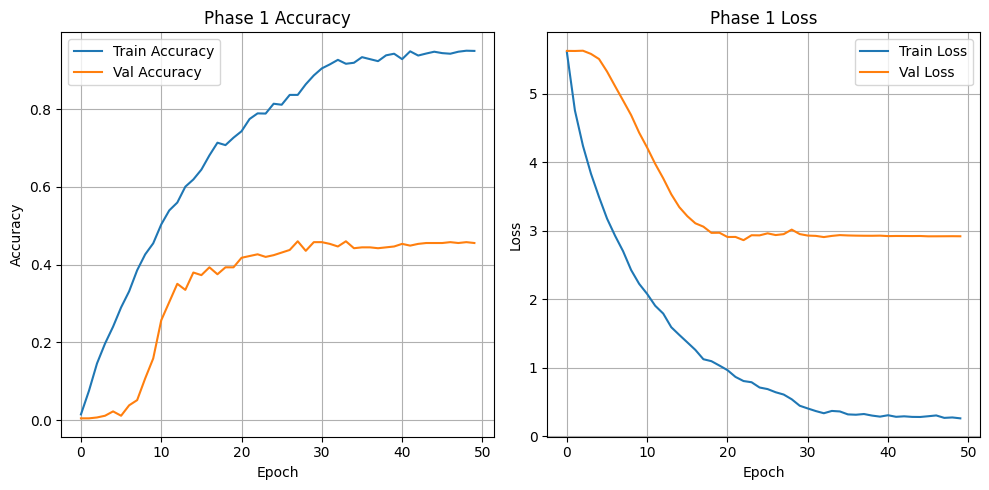

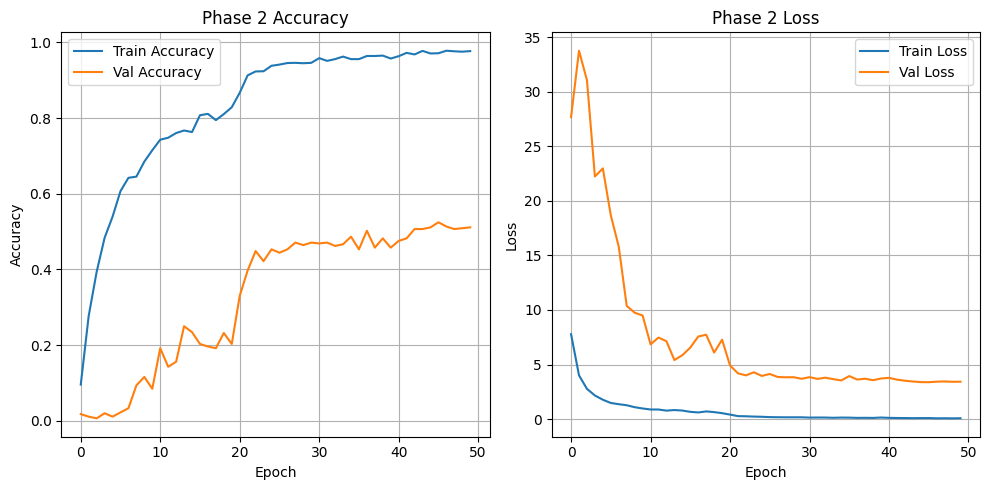

In [17]:
def plot_history(history, title_prefix):
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])

    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Usage
plot_history(history1, 'Phase 1')
plot_history(history2, 'Phase 2')

In [18]:
import numpy as np

y_true = []
y_pred = []
y_pred_top5 = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)

    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
    y_pred_top5.extend(np.argsort(preds, axis=1)[:, -5:])

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_top5 = np.array(y_pred_top5)

In [19]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_true,
        y_pred,
        digits=3,
        zero_division=0
    )
)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000         2
           1      0.000     0.000     0.000         2
           2      1.000     1.000     1.000         2
           3      0.000     0.000     0.000         2
           4      1.000     0.500     0.667         2
           5      0.000     0.000     0.000         2
           6      0.000     0.000     0.000         2
           7      0.000     0.000     0.000         2
           8      0.000     0.000     0.000         2
           9      0.500     0.500     0.500         2
          10      0.000     0.000     0.000         2
          11      1.000     0.500     0.667         2
          12      0.500     0.500     0.500         2
          13      0.500     0.500     0.500         2
          14      0.000     0.000     0.000         2
          15      1.000     1.000     1.000         2
          16      0.333     0.500     0.400         2
          17      0.000    

182 classes with acc ≥ 0.3


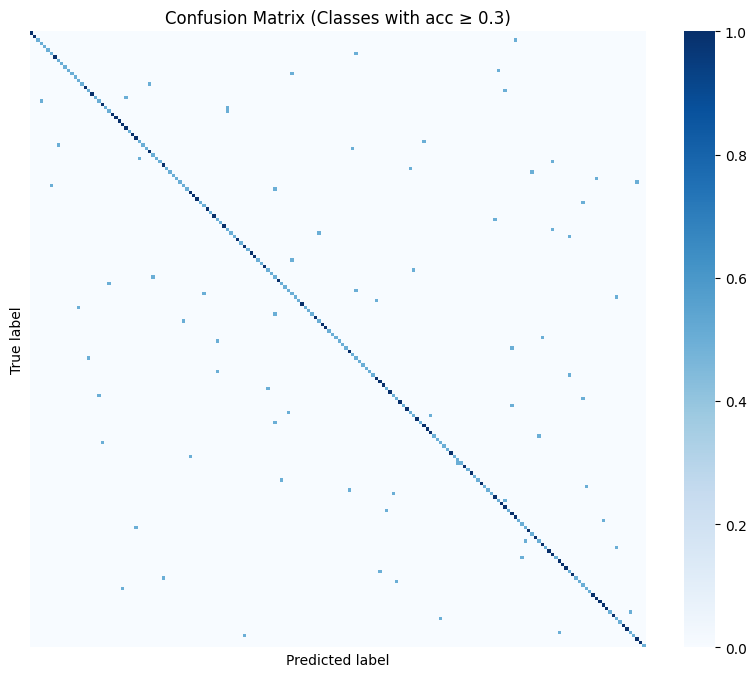

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)
#Calculer l’accuracy par classe (diagonale)
per_class_acc = np.diag(cm_norm)
#Sélectionner les classes “bonnes”
threshold = 0.3
good_classes = np.where(per_class_acc >= threshold)[0]

print(f"{len(good_classes)} classes with acc ≥ {threshold}")
#Filtrer la matrice
cm_good = cm_norm[np.ix_(good_classes, good_classes)]
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_good,
    cmap="Blues",
    square=True,
    cbar=True,
    xticklabels=False,
    yticklabels=False
)

plt.title(f"Confusion Matrix (Classes with acc ≥ {threshold})")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [22]:
MODEL_PATH = '/content/drive/MyDrive/IRIS_RECOGNITION_PROJECT/iris_model.keras'
model = tf.keras.models.load_model(MODEL_PATH)

In [6]:
import tensorflow as tf
import numpy as np
from pathlib import Path
import json

class IrisRecognizer:
    """Class for performing iris recognition on new images"""

    def __init__(self, model_path, class_mapping_path=None):
        """
        Initialize the iris recognizer
        """
        self.model = tf.keras.models.load_model(model_path)
        self.img_size = (224, 224)

        # Load class mapping if available
        if class_mapping_path and Path(class_mapping_path).exists():
            with open(class_mapping_path, 'r') as f:
                self.class_names = json.load(f)
        else:
            self.class_names = None

    def preprocess_image(self, image_path):
        """
        Preprocess a single iris image for prediction
        """
        img = tf.io.read_file(str(image_path))
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, self.img_size)

        # If model is ResNet-based, use its preprocess_input
        img = tf.keras.applications.resnet.preprocess_input(img)
        img = tf.expand_dims(img, 0)  # Add batch dimension

        return img

    def predict_single(self, image_path, top_k=5):
        """
        Predict the identity for a single iris image
        """
        img = self.preprocess_image(image_path)
        predictions = self.model.predict(img, verbose=0)[0]

        top_indices = np.argsort(predictions)[-top_k:][::-1]
        top_probs = predictions[top_indices]

        results = {
            'top_1_class': int(top_indices[0]),
            'top_1_confidence': float(top_probs[0]),
            'top_k_predictions': []
        }

        for idx, prob in zip(top_indices, top_probs):
            pred = {
                'class_id': int(idx),
                'confidence': float(prob),
                'percentage': f"{prob * 100:.2f}%"
            }
            if self.class_names:
                # Handles both dict or list
                if isinstance(self.class_names, dict):
                    pred['class_name'] = self.class_names.get(str(idx), f"Class_{idx}")
                elif isinstance(self.class_names, list) and idx < len(self.class_names):
                    pred['class_name'] = self.class_names[idx]
            results['top_k_predictions'].append(pred)

        return results

    def predict_batch(self, image_paths, batch_size=32):
        """
        Predict identities for multiple iris images
        """
        results = []

        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_images = [self.preprocess_image(p)[0] for p in batch_paths]  # remove batch dim
            batch_tensor = tf.stack(batch_images)
            predictions = self.model.predict(batch_tensor, verbose=0)

            for path, pred in zip(batch_paths, predictions):
                top_idx = np.argmax(pred)
                result = {
                    'image_path': str(path),
                    'predicted_class': int(top_idx),
                    'confidence': float(pred[top_idx]),
                    'percentage': f"{pred[top_idx] * 100:.2f}%"
                }
                if self.class_names:
                    if isinstance(self.class_names, dict):
                        result['class_name'] = self.class_names.get(str(top_idx), f"Class_{top_idx}")
                    elif isinstance(self.class_names, list) and top_idx < len(self.class_names):
                        result['class_name'] = self.class_names[top_idx]

                results.append(result)

        return results



# ===== USAGE EXAMPLES =====
if __name__ == "__main__":
    recognizer = IrisRecognizer(
        model_path='/content/drive/MyDrive/IRIS_RECOGNITION_PROJECT/iris_model.keras'
    )

    test_image = "/content/drive/MyDrive/IRIS_RECOGNITION_PROJECT/test.jpg"

    # Single prediction
    result = recognizer.predict_single(test_image, top_k=5)
    print("\nTop-1 Prediction:")
    print(f"  Class: {result['top_1_class']}")
    print(f"  Confidence: {result['top_1_confidence']:.4f} ({result['top_1_confidence']*100:.2f}%)")

    print("\nTop-5 Predictions:")
    for i, pred in enumerate(result['top_k_predictions'], 1):
        class_name = pred.get('class_name', f"Class_{pred['class_id']}")
        print(f"  {i}. {class_name}: {pred['percentage']}")


Top-1 Prediction:
  Class: 19
  Confidence: 1.0000 (100.00%)

Top-5 Predictions:
  1. Class_19: 100.00%
  2. Class_100: 0.00%
  3. Class_228: 0.00%
  4. Class_22: 0.00%
  5. Class_12: 0.00%
